# Observe Filters
The purpose of this notebook is to examine some of the filters produced by the model. For this experiement we will be looking at the SESD architecture with the MSE Loss Function.

In [2]:
import os
import time
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from Trained_Colourization_Models import CustomDataset, Testing_Image

### Load Model from Checkpoint

In [4]:
class Encoder_SESD(nn.Module):
    def __init__(self):
        super(Encoder_SESD,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
            
        )

    def forward(self, x):
        self.model = self.model.float()
        return self.model(x.float())


class FusionLayer_SESD(nn.Module):
    def __init__(self):
        super(FusionLayer_SESD,self).__init__()

    def forward(self, inputs, mask=None):
        ip, emb = inputs
        emb = torch.stack([torch.stack([emb],dim=2)],dim=3)
        emb = emb.repeat(1,1,ip.shape[2],ip.shape[3])
        fusion = torch.cat((ip,emb),1)
        return fusion


class Decoder_SESD(nn.Module):
    def __init__(self, input_depth):
        super(Decoder_SESD,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=input_depth, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),


            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),


            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2.0),
            
            nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels=2, out_channels=2, kernel_size=1, stride=1, padding=0),     
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Colorization_SESD(nn.Module):
    def __init__(self, depth_after_fusion):
        super(Colorization_SESD,self).__init__()
        self.encoder = Encoder_SESD()
        self.fusion = FusionLayer_SESD()
        self.after_fusion = nn.Conv2d(in_channels=1256, out_channels=depth_after_fusion,kernel_size=1, stride=1,padding=0)
        self.bnorm = nn.BatchNorm2d(256)
        self.decoder = Decoder_SESD(depth_after_fusion)

    def forward(self, img_l, img_emb):
        img_enc = self.encoder(img_l)
        fusion = self.fusion([img_enc, img_emb])
        fusion = self.after_fusion(fusion)
        fusion = self.bnorm(fusion)
        return self.decoder(fusion), img_enc, fusion

In [8]:
checkpoint_path="Models/sesd_checkpoint19.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Colorization_SESD(256).to(device)
checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

inception_model = models.inception_v3(pretrained=True).float().to(device)
inception_model = inception_model.float()
inception_model.eval()

print("This is a different implementation of the model that allows us to observe the filters")

/Users/harshraod/miniconda3/envs/LearnPyTorch/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/harshraod/miniconda3/envs/LearnPyTorch/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


This is a diffrent implementation of the model that allows us to observe the filters


In [14]:
def _concatente_and_colorize(im_lab, img_ab):
        # Assumption is that im_lab is of size [1,1,224,224]
        np_img = im_lab[0].cpu().detach().numpy().transpose(1,2,0)
        lab = np.empty([*np_img.shape[0:2], 3],dtype=np.float32)
        lab[:, :, 0] = np.squeeze(((np_img + 1) * 50))
        lab[:, :, 1:] = img_ab[0].cpu().detach().numpy().transpose(1,2,0) * 127
        np_img = cv2.cvtColor(lab,cv2.COLOR_Lab2RGB) 
        color_im = torch.stack([torchvision.transforms.ToTensor()(np_img)],dim=0)
        return color_im

test_dataset = CustomDataset('coco2017/test2017','test')
input_image = Testing_Image(test_dataset, filename='000000000019.jpg')

inception_img = input_image.get_inception_img(direct_input=False)
img_embs = inception_model(inception_img.float().unsqueeze(0))
output_ab, encoder_output, fusion_output = model(input_image.get_encoder_img(direct_input=False).unsqueeze(0), img_embs)

# Processing for final image
new_lab_image = torch.stack([input_image.get_encoder_img(direct_input=True)[:,0,:,:]], dim=1)
color_img = _concatente_and_colorize(new_lab_image, output_ab)
color_img_jpg = color_img[0].detach().numpy().transpose(1,2,0)

File[0]: 000000339995.jpg | Total Files: 40670 | Process: test


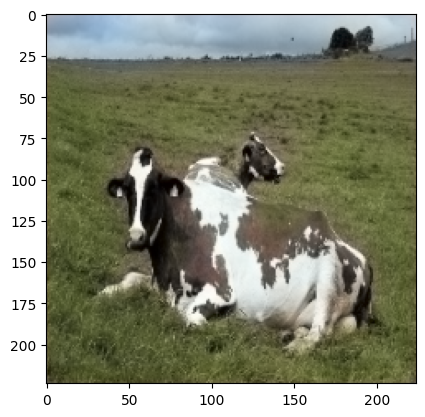

In [15]:
plt.imshow(color_img_jpg)

### Observe Filters

In [22]:
encoder_output_filters = encoder_output.squeeze().detach().numpy()
after_fusion_output_filters = fusion_output.squeeze().detach().numpy()

print(f"Shape of encoder_output_filters: {encoder_output_filters.shape}")
print(f"Shape of after_fusion_output_filters: {after_fusion_output_filters.shape}")

Shape of encoder_output_filters: (256, 28, 28)
Shape of after_fusion_output_filters: (256, 28, 28)


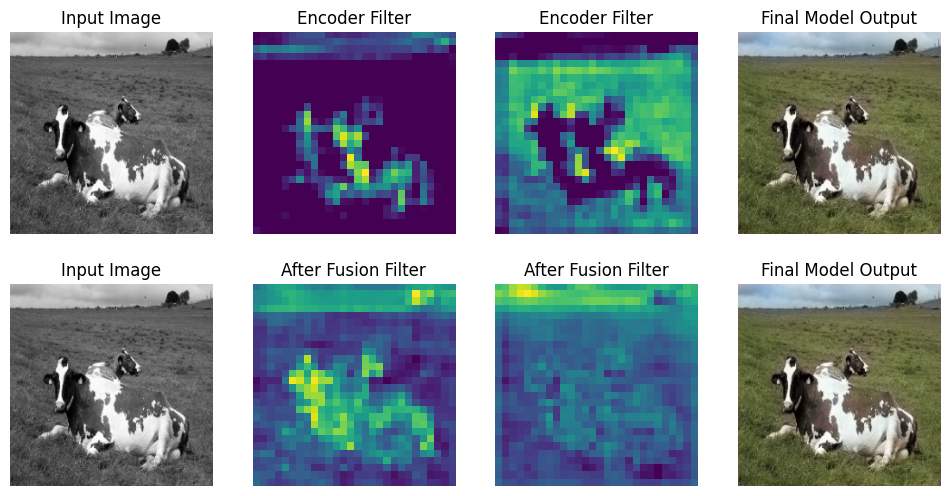

In [73]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0][0].imshow(input_image.get_gray(), cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title("Input Image")
ax[1][0].imshow(input_image.get_gray(), cmap='gray')
ax[1][0].axis('off')
ax[1][0].set_title("Input Image")

# Encoder Layer Filters
ax[0][1].imshow(encoder_output_filters[1])
ax[0][1].axis('off')
ax[0][1].set_title("Encoder Filter")
ax[0][2].imshow(encoder_output_filters[8])
ax[0][2].axis('off')
ax[0][2].set_title("Encoder Filter")

# After Fusion Filters
ax[1][1].imshow(after_fusion_output_filters[134])
ax[1][1].axis('off')
ax[1][1].set_title("After Fusion Filter")
ax[1][2].imshow(after_fusion_output_filters[139])
ax[1][2].axis('off')
ax[1][2].set_title("After Fusion Filter")

# Final Ouput
ax[0][3].imshow(color_img_jpg)
ax[0][3].axis('off')
ax[0][3].set_title("Final Model Output")
ax[1][3].imshow(color_img_jpg)
ax[1][3].axis('off')
ax[1][3].set_title("Final Model Output")

plt.show()

Text(0.5, 1.0, 'Final Model Output')

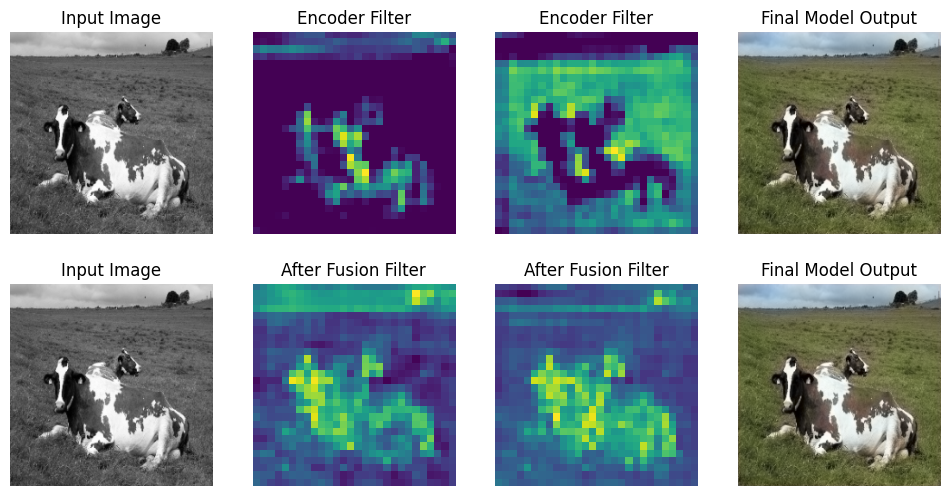

In [76]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0][0].imshow(input_image.get_gray(), cmap='gray')
ax[0][0].axis('off')
ax[0][0].set_title("Input Image")
ax[1][0].imshow(input_image.get_gray(), cmap='gray')
ax[1][0].axis('off')
ax[1][0].set_title("Input Image")

# Encoder Layer Filters
ax[0][1].imshow(encoder_output_filters[1])
ax[0][1].axis('off')
ax[0][1].set_title("Encoder Filter")
ax[0][2].imshow(encoder_output_filters[8])
ax[0][2].axis('off')
ax[0][2].set_title("Encoder Filter")

# After Fusion Filters
ax[1][1].imshow(after_fusion_output_filters[134])
ax[1][1].axis('off')
ax[1][1].set_title("After Fusion Filter")
ax[1][2].imshow(after_fusion_output_filters[7])
ax[1][2].axis('off')
ax[1][2].set_title("After Fusion Filter")

# Final Ouput
ax[0][3].imshow(color_img_jpg)
ax[0][3].axis('off')
ax[0][3].set_title("Final Model Output")
ax[1][3].imshow(color_img_jpg)
ax[1][3].axis('off')
ax[1][3].set_title("Final Model Output")